### 聚类分析

#### 1、算法

- KMeans
- TSNE

#### 2、分析方法：

- RFM
  
#### 3、分析过程：

- KMeans对样本分类
- TSNE可视化，查看数据有没有分开
- 采用RFM分析不同类别的样本之间的差异，定义各个类别的实际含义

### 实现

#### 1、聚类

In [35]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [36]:
# 参数初始化
INPUT_FILE = './data/consumption_data.xls'  # 销量及其他属性数据
OUTPUT_FILE = './tmp/data_type.xls'  # 保存结果的文件名
K = 3  # 聚类的类别
ITERATION = 500  # 聚类最大循环次数

data = pd.read_excel(INPUT_FILE, index_col = 'Id')  # 读取数据
data_zs = 1.0*(data - data.mean())/data.std()  # 数据标准化

In [37]:
data_zs.head()

,R,F,M
Id,,,
1,0.764186,-0.493579,-1.158711
2,-1.024757,-0.630079,0.622527
3,-0.950217,0.871423,-0.341103
4,-1.024757,0.188922,-1.158432
5,-0.204824,-0.357079,1.189868


In [38]:
model = KMeans(n_clusters=K, n_jobs=4, max_iter=ITERATION, random_state=2020)  # 分为k类，并发数4
model.fit(data_zs)  # 开始聚类

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=3, n_init=10, n_jobs=4, precompute_distances='auto',
    random_state=2020, tol=0.0001, verbose=0)

In [39]:
# 简单打印结果
r1 = pd.Series(model.labels_).value_counts()  # 统计各个类别的数目
r2 = pd.DataFrame(model.cluster_centers_)  # 找出聚类中心
r = pd.concat([r2, r1], axis = 1)  # 横向连接（0是纵向），得到聚类中心对应的类别下的数目
r.columns = list(data.columns) + ['类别数目']  # 重命名表头
print(r)

          R         F         M  类别数目
0  3.455055 -0.295654  0.449123    40
1 -0.149353 -0.658893 -0.271780   559
2 -0.160451  1.114802  0.392844   341


In [40]:
# 详细输出原始数据及其类别
r = pd.concat([data, pd.Series(model.labels_, index = data.index)], axis = 1)   # 详细输出每个样本对应的类别
r.columns = list(data.columns) + ['聚类类别']  # 重命名表头
r.to_excel(OUTPUT_FILE)  # 保存结果

In [41]:
r.head()

,R,F,M,聚类类别
Id,,,,
1,27,6,232.61,1
2,3,5,1507.11,1
3,4,16,817.62,2
4,3,11,232.81,1
5,14,7,1913.05,1


#### 2、可视化

In [44]:
tsne = TSNE(random_state=2020)
tsne.fit_transform(data_zs)  # 进行数据降维
tsne = pd.DataFrame(tsne.embedding_, index = data_zs.index)  # 转换数据格式

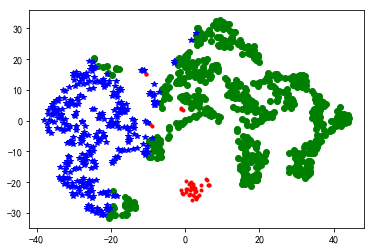

In [46]:
# 不同类别用不同颜色和样式绘图
d = tsne[r['聚类类别'] == 0]
plt.plot(d[0], d[1], 'r.')
d = tsne[r['聚类类别'] == 1]
plt.plot(d[0], d[1], 'go')
d = tsne[r['聚类类别'] == 2]
plt.plot(d[0], d[1], 'b*')
plt.show()

#### 3、类别分析

In [42]:
def density_plot(data):  # 自定义作图函数
    p = data.plot(kind='kde', linewidth = 2, subplots = True, sharex = False)
    [p[i].set_ylabel(u'密度') for i in range(K)]
    plt.legend()
    return plt

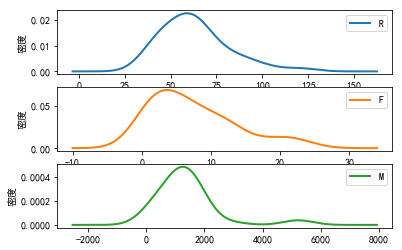

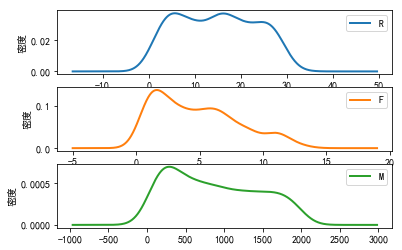

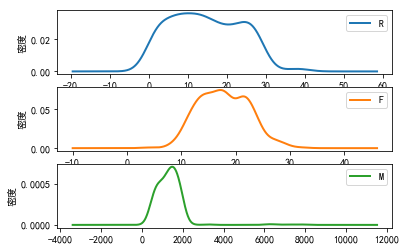

In [43]:
pic_output = './tmp/pd'  # 概率密度图文件名前缀
for i in range(K):
    density_plot(data[r[u'聚类类别']==i]).savefig(u'%s%s.png' %(pic_output, i))

**分群1**：R间隔相对较大，间隔分布在30-80天；消费次数集中在0-15次；消费金额在2000元以内。

**分群2**：R间隔相对较小，主要集中在0-30天；消费次数集中在0-12次；消费金额在1800元以内。

**分群3**：R间隔相对较小，主要集中在0-30天；消费次数集中在10-25次；消费金额在500-2000元。

**对比分析：**  

- 分群1：时间间隔较长，消费次数多，消费金额也不是很高，是价值较低的客户；
- 分群2：时间间隔、消费次数和消费金额处于中等水平，代表一般客户；
- 分群3：时间间隔较短，消费次数多，且消费金额较大，是高消费、高价值人群；

### 航空公司客户价值分析

分析方法：LRFMC

> 注：RFM模型可根据实际应用领域，调整评价的维度。

- **分类**：借助航空公司客户数据，对客户进行分类；
- **价值分析**：对不同的客户类别进行**特征分析**，比较不同类客户的客户价值；
- **制定策略**：对不同价值的客户类别提供个性化服务，制定相应的营销策略；

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from datetime import datetime
from sklearn.cluster import KMeans 

#### 01 - data_explore

对数据进行基本的探索:  

返回缺失值个数以及最大最小值

In [60]:
datafile= './data/air_data.csv'  # 航空原始数据,第一行为属性标签
resultfile = './tmp/explore.csv'  # 数据探索结果表

# 读取原始数据，指定UTF-8编码（需要用文本编辑器将数据装换为UTF-8编码）
data = pd.read_csv(datafile, encoding = 'utf-8')

# 包括对数据的基本描述，percentiles参数是指定计算多少的分位数表（如1/4分位数、中位数等）
explore = data.describe(percentiles = [], include = 'all').T  # T是转置，转置后更方便查阅
explore['null'] = len(data)-explore['count']  # describe()函数自动计算非空值数，需要手动计算空值数

explore = explore[['null', 'max', 'min']]
explore.columns = [u'空值数', u'最大值', u'最小值']  # 表头重命名
'''
这里只选取部分探索结果。
describe()函数自动计算的字段有count（非空值数）、unique（唯一值数）、top（频数最高者）、
freq（最高频数）、mean（平均值）、std（方差）、min（最小值）、50%（中位数）、max（最大值）
'''

explore.to_csv(resultfile)  # 导出结果

In [61]:
explore.head()

,空值数,最大值,最小值
MEMBER_NO,0,62988,1
FFP_DATE,0,NaN,NaN
FIRST_FLIGHT_DATE,0,NaN,NaN
GENDER,3,NaN,NaN
FFP_TIER,0,6,4


#### 02 - data_distribution

对数据的分布分析

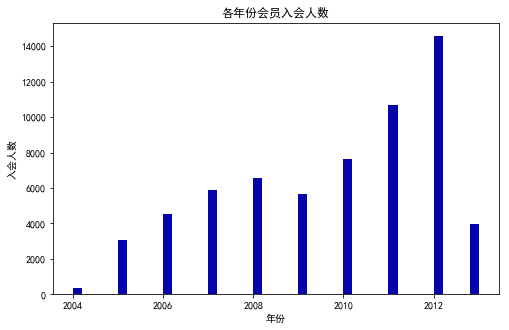

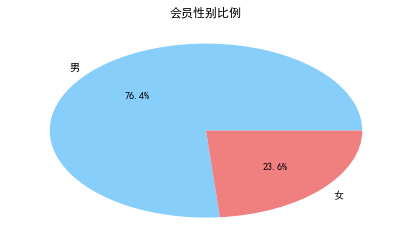

C:\Users\zh\Anaconda3\lib\site-packages\matplotlib\__init__.py:1855: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


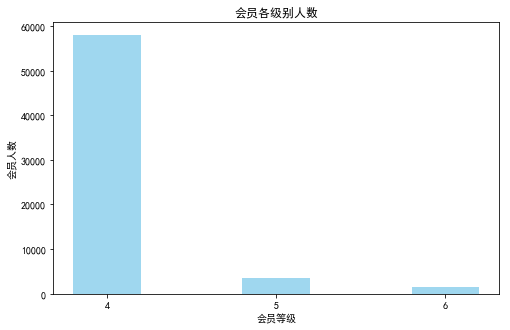

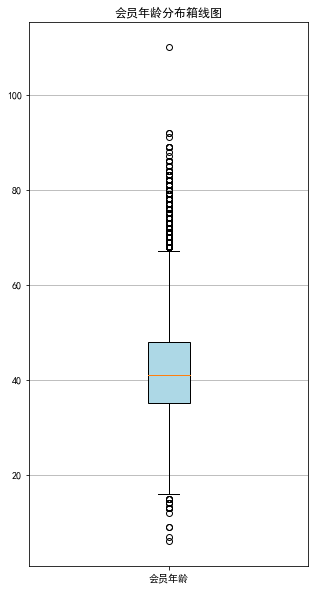

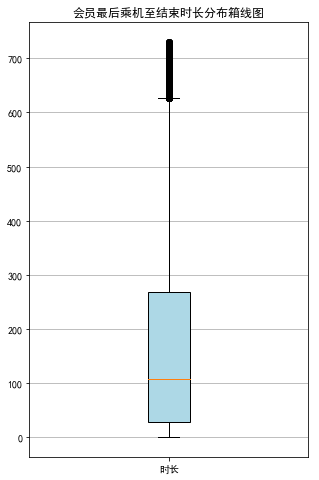

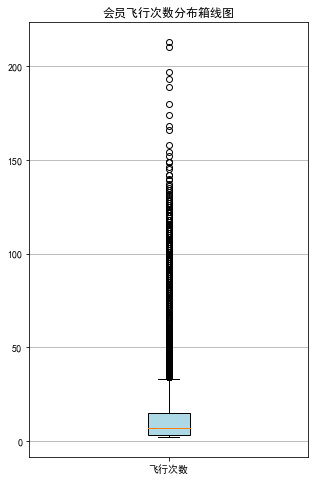

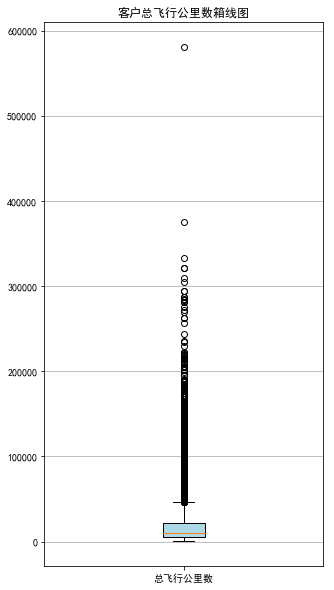

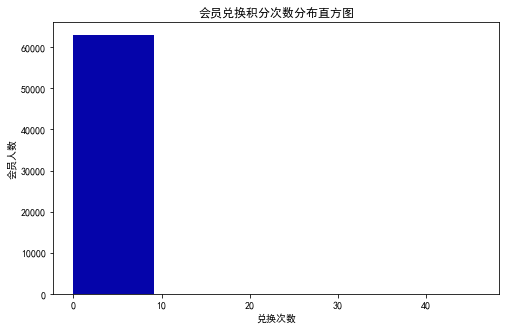

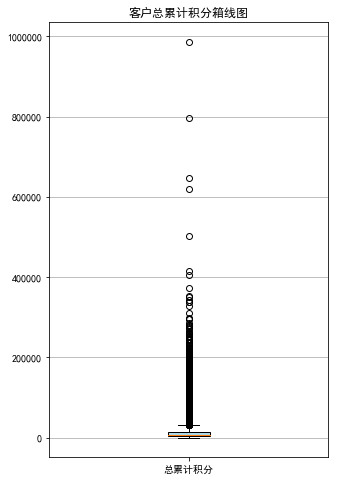

C:\Users\zh\Anaconda3\lib\site-packages\ipykernel_launcher.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\zh\Anaconda3\lib\site-packages\ipykernel_launcher.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


相关性矩阵为：
                 FFP_TIER  FLIGHT_COUNT  LAST_TO_END  SEG_KM_SUM  \
FFP_TIER        1.000000      0.582447    -0.206313    0.522350   
FLIGHT_COUNT    0.582447      1.000000    -0.404999    0.850411   
LAST_TO_END    -0.206313     -0.404999     1.000000   -0.369509   
SEG_KM_SUM      0.522350      0.850411    -0.369509    1.000000   
EXCHANGE_COUNT  0.342355      0.502501    -0.169717    0.507819   
Points_Sum      0.559249      0.747092    -0.292027    0.853014   
AGE             0.076245      0.075309    -0.027654    0.087285   
ffp_year       -0.116510     -0.188181     0.117913   -0.171508   

                EXCHANGE_COUNT  Points_Sum       AGE  ffp_year  
FFP_TIER              0.342355    0.559249  0.076245 -0.116510  
FLIGHT_COUNT          0.502501    0.747092  0.075309 -0.188181  
LAST_TO_END          -0.169717   -0.292027 -0.027654  0.117913  
SEG_KM_SUM            0.507819    0.853014  0.087285 -0.171508  
EXCHANGE_COUNT        1.000000    0.578581  0.032760 -0.216610

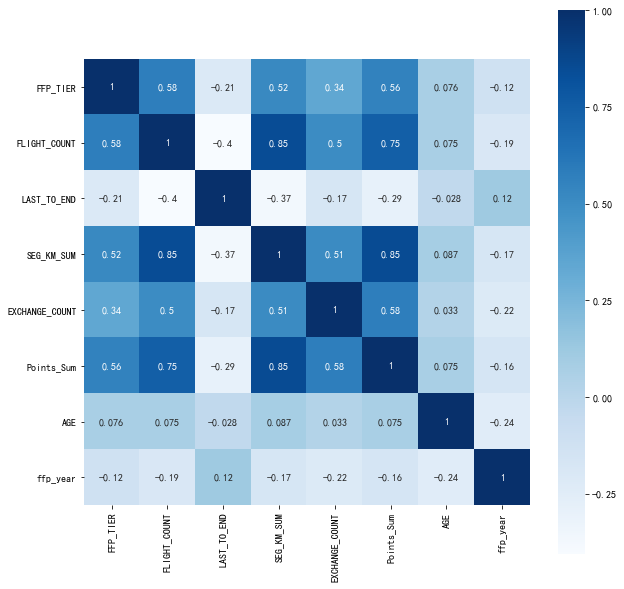

<function matplotlib.pyplot.close(*args)>

In [62]:
datafile= './data/air_data.csv'  # 航空原始数据,第一行为属性标签

# 读取原始数据，指定UTF-8编码（需要用文本编辑器将数据装换为UTF-8编码）
data = pd.read_csv(datafile, encoding = 'utf-8')

# 客户信息类别
# 提取会员入会年份
ffp = data['FFP_DATE'].apply(lambda x:datetime.strptime(x,'%Y/%m/%d'))
ffp_year = ffp.map(lambda x : x.year)
# 绘制各年份会员入会人数直方图
fig = plt.figure(figsize = (8 ,5))  # 设置画布大小
plt.rcParams['font.sans-serif'] = 'SimHei'  # 设置中文显示
plt.rcParams['axes.unicode_minus'] = False
plt.hist(ffp_year, bins='auto', color='#0504aa')
plt.xlabel('年份')
plt.ylabel('入会人数')
plt.title('各年份会员入会人数')
plt.show()
plt.close

# 提取会员不同性别人数
male = pd.value_counts(data['GENDER'])['男']
female = pd.value_counts(data['GENDER'])['女']
# 绘制会员性别比例饼图
fig = plt.figure(figsize = (7 ,4))  # 设置画布大小
plt.pie([ male, female], labels=['男','女'], colors=['lightskyblue', 'lightcoral'],
       autopct='%1.1f%%')
plt.title('会员性别比例')
plt.show()
plt.close

# 提取不同级别会员的人数
lv_four = pd.value_counts(data['FFP_TIER'])[4]
lv_five = pd.value_counts(data['FFP_TIER'])[5]
lv_six = pd.value_counts(data['FFP_TIER'])[6]
# 绘制会员各级别人数条形图
fig = plt.figure(figsize = (8 ,5))  # 设置画布大小
plt.bar(left=range(3), height=[lv_four,lv_five,lv_six], width=0.4, alpha=0.8, color='skyblue')
plt.xticks([index for index in range(3)], ['4','5','6'])
plt.xlabel('会员等级')
plt.ylabel('会员人数')
plt.title('会员各级别人数')
plt.show()
plt.close()

# 提取会员年龄
age = data['AGE'].dropna()
age = age.astype('int64')
# 绘制会员年龄分布箱型图
fig = plt.figure(figsize = (5 ,10))
plt.boxplot(age, 
            patch_artist=True,
            labels = ['会员年龄'],  # 设置x轴标题
            boxprops = {'facecolor':'lightblue'})  # 设置填充颜色
plt.title('会员年龄分布箱线图')
# 显示y坐标轴的底线
plt.grid(axis='y')
plt.show()
plt.close



# 代码7-3

# 乘机信息类别
lte = data['LAST_TO_END']
fc = data['FLIGHT_COUNT']
sks = data['SEG_KM_SUM']

# 绘制最后乘机至结束时长箱线图
fig = plt.figure(figsize = (5 ,8))
plt.boxplot(lte, 
            patch_artist=True,
            labels = ['时长'],  # 设置x轴标题
            boxprops = {'facecolor':'lightblue'})  # 设置填充颜色
plt.title('会员最后乘机至结束时长分布箱线图')
# 显示y坐标轴的底线
plt.grid(axis='y')
plt.show()
plt.close

# 绘制客户飞行次数箱线图
fig = plt.figure(figsize = (5 ,8))
plt.boxplot(fc, 
            patch_artist=True,
            labels = ['飞行次数'],  # 设置x轴标题
            boxprops = {'facecolor':'lightblue'})  # 设置填充颜色
plt.title('会员飞行次数分布箱线图')
# 显示y坐标轴的底线
plt.grid(axis='y')
plt.show()
plt.close

# 绘制客户总飞行公里数箱线图
fig = plt.figure(figsize = (5 ,10))
plt.boxplot(sks, 
            patch_artist=True,
            labels = ['总飞行公里数'],  # 设置x轴标题
            boxprops = {'facecolor':'lightblue'})  # 设置填充颜色
plt.title('客户总飞行公里数箱线图')
# 显示y坐标轴的底线
plt.grid(axis='y')
plt.show()
plt.close



# 代码7-4

# 积分信息类别
# 提取会员积分兑换次数
ec = data['EXCHANGE_COUNT']
# 绘制会员兑换积分次数直方图
fig = plt.figure(figsize = (8 ,5))  # 设置画布大小
plt.hist(ec, bins=5, color='#0504aa')
plt.xlabel('兑换次数')
plt.ylabel('会员人数')
plt.title('会员兑换积分次数分布直方图')
plt.show()
plt.close

# 提取会员总累计积分
ps = data['Points_Sum']
# 绘制会员总累计积分箱线图
fig = plt.figure(figsize = (5 ,8))
plt.boxplot(ps, 
            patch_artist=True,
            labels = ['总累计积分'],  # 设置x轴标题
            boxprops = {'facecolor':'lightblue'})  # 设置填充颜色
plt.title('客户总累计积分箱线图')
# 显示y坐标轴的底线
plt.grid(axis='y')
plt.show()
plt.close



# 代码7-5

# 提取属性并合并为新数据集
data_corr = data[['FFP_TIER','FLIGHT_COUNT','LAST_TO_END',
                  'SEG_KM_SUM','EXCHANGE_COUNT','Points_Sum']]
age1 = data['AGE'].fillna(0)
data_corr['AGE'] = age1.astype('int64')
data_corr['ffp_year'] = ffp_year

# 计算相关性矩阵
dt_corr = data_corr.corr(method = 'pearson')
print('相关性矩阵为：\n',dt_corr)

# 绘制热力图
import seaborn as sns
plt.subplots(figsize=(10, 10)) # 设置画面大小 
sns.heatmap(dt_corr, annot=True, vmax=1, square=True, cmap='Blues') 
plt.show()
plt.close

#### 03 - data_clean

处理缺失值与异常值

In [63]:
datafile = './data/air_data.csv'  # 航空原始数据路径
cleanedfile = './tmp/data_cleaned.csv'  # 数据清洗后保存的文件路径

# 读取数据
airline_data = pd.read_csv(datafile,encoding = 'utf-8')
print('原始数据的形状为：',airline_data.shape)

# 去除票价为空的记录
airline_notnull = airline_data.loc[airline_data['SUM_YR_1'].notnull() & 
                                   airline_data['SUM_YR_2'].notnull(),:]
print('删除缺失记录后数据的形状为：',airline_notnull.shape)

# 只保留票价非零的，或者平均折扣率不为0且总飞行公里数大于0的记录。
index1 = airline_notnull['SUM_YR_1'] != 0
index2 = airline_notnull['SUM_YR_2'] != 0
index3 = (airline_notnull['SEG_KM_SUM']> 0) & (airline_notnull['avg_discount'] != 0)
index4 = airline_notnull['AGE'] > 100  # 去除年龄大于100的记录
airline = airline_notnull[(index1 | index2) & index3 & ~index4]
print('数据清洗后数据的形状为：',airline.shape)

airline.to_csv(cleanedfile)  # 保存清洗后的数据

原始数据的形状为： (62988, 44)
删除缺失记录后数据的形状为： (62299, 44)
数据清洗后数据的形状为： (62043, 44)


#### 04 - zscore_data

属性选择、构造与数据标准化

In [64]:
# 读取数据清洗后的数据
cleanedfile = './tmp/data_cleaned.csv'  # 数据清洗后保存的文件路径
airline = pd.read_csv(cleanedfile, encoding = 'utf-8')
# 选取需求属性
airline_selection = airline[['FFP_DATE','LOAD_TIME','LAST_TO_END',
                                     'FLIGHT_COUNT','SEG_KM_SUM','avg_discount']]
print('筛选的属性前5行为：\n',airline_selection.head())


# 代码7-8

# 构造属性L
L = pd.to_datetime(airline_selection['LOAD_TIME']) - \
pd.to_datetime(airline_selection['FFP_DATE'])
L = L.astype('str').str.split().str[0]
L = L.astype('int')/30

# 合并属性
airline_features = pd.concat([L,airline_selection.iloc[:,2:]],axis = 1)
airline_features.columns = ['L','R','F','M','C']
print('构建的LRFMC属性前5行为：\n',airline_features.head())

# 数据标准化
from sklearn.preprocessing import StandardScaler
data = StandardScaler().fit_transform(airline_features)
np.savez('./tmp/airline_scale.npz',data)
print('标准化后LRFMC五个属性为：\n',data[:5,:])

筛选的属性前5行为：
     FFP_DATE  LOAD_TIME  LAST_TO_END  FLIGHT_COUNT  SEG_KM_SUM  avg_discount
0  2006/11/2  2014/3/31            1           210      580717      0.961639
1  2007/2/19  2014/3/31            7           140      293678      1.252314
2   2007/2/1  2014/3/31           11           135      283712      1.254676
3  2008/8/22  2014/3/31           97            23      281336      1.090870
4  2009/4/10  2014/3/31            5           152      309928      0.970658
构建的LRFMC属性前5行为：
            L   R    F       M         C
0  90.200000   1  210  580717  0.961639
1  86.566667   7  140  293678  1.252314
2  87.166667  11  135  283712  1.254676
3  68.233333  97   23  281336  1.090870
4  60.533333   5  152  309928  0.970658
标准化后LRFMC五个属性为：
 [[ 1.43579256 -0.94493902 14.03402401 26.76115699  1.29554188]
 [ 1.30723219 -0.91188564  9.07321595 13.12686436  2.86817777]
 [ 1.32846234 -0.88985006  8.71887252 12.65348144  2.88095186]
 [ 0.65853304 -0.41608504  0.78157962 12.54062193  1.99471546]


#### 05 - KMeans_cluster

In [91]:
# 读取标准化后的数据
airline_scale = np.load('./tmp/airline_scale.npz')['arr_0']

In [93]:
airline_scale = pd.DataFrame(airline_scale, columns=['ZL','ZR','ZF','ZM','ZC'])

选择K值

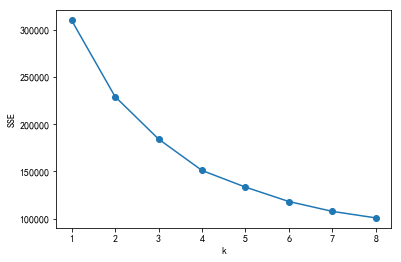

In [94]:
SSE = []  # 存放每次结果的误差平方和
for k in range(1,9):
    estimator = KMeans(n_clusters=k)  # 构造聚类器
    estimator.fit(airline_scale)
    SSE.append(estimator.inertia_) # estimator.inertia_获取聚类准则的总和
X = range(1,9)
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(X,SSE,'o-')
plt.show()

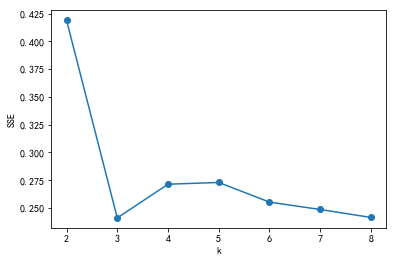

In [86]:
from sklearn import metrics

SC = []  # 存放每次结果的误差平方和
for k in range(2,9):
    estimator = KMeans(n_clusters=k)  # 构造聚类器
    labels = estimator.fit(airline_scale[:10000]).labels_
    SC.append(metrics.silhouette_score(airline_scale[:10000], labels)) 
X = range(2,9)
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(X,SC,'o-')
plt.show()

因此，K取4或5

K-means聚类

各类聚类中心为：
 [[-0.70022016 -0.4148591  -0.16116192 -0.1609779  -0.2550709 ]
 [-0.31365557  1.68628985 -0.57402225 -0.53682279 -0.17332449]
 [ 1.1606821  -0.37729768 -0.08690742 -0.09484273 -0.15591932]
 [ 0.48337963 -0.79937347  2.48319841  2.42472188  0.30863168]
 [ 0.05219076 -0.00264741 -0.22674532 -0.23116846  2.19158505]]
各样本的类别标签为：
 [3 3 3 ... 0 1 1]
最终每个类别的数目为：
 0    24661
2    15739
1    12125
3     5336
4     4182
dtype: int64
         ZL        ZR        ZF        ZM        ZC
0                                                  
3 -0.700220 -0.414859 -0.161162 -0.160978 -0.255071
4 -0.313656  1.686290 -0.574022 -0.536823 -0.173324
2  1.160682 -0.377298 -0.086907 -0.094843 -0.155919
0  0.483380 -0.799373  2.483198  2.424722  0.308632
1  0.052191 -0.002647 -0.226745 -0.231168  2.191585


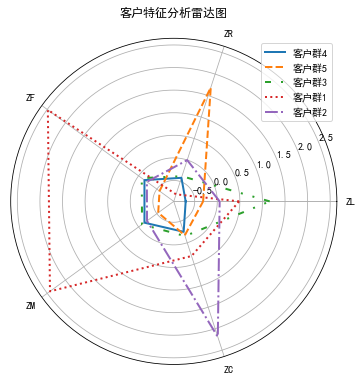

<function matplotlib.pyplot.close(*args)>

In [95]:
k = 5  # 确定聚类中心数

# 构建模型，随机种子设为123
kmeans_model = KMeans(n_clusters=k,n_jobs=4,random_state=2020)
fit_kmeans = kmeans_model.fit(airline_scale)  # 模型训练

# 查看聚类结果
kmeans_cc = kmeans_model.cluster_centers_  # 聚类中心
print('各类聚类中心为：\n',kmeans_cc)
kmeans_labels = kmeans_model.labels_  # 样本的类别标签
print('各样本的类别标签为：\n',kmeans_labels)
r1 = pd.Series(kmeans_model.labels_).value_counts()  # 统计不同类别样本的数目
print('最终每个类别的数目为：\n',r1)
# 输出聚类分群的结果
cluster_center = pd.DataFrame(kmeans_model.cluster_centers_,\
             columns = ['ZL','ZR','ZF','ZM','ZC'])   # 将聚类中心放在数据框中
cluster_center.index = pd.DataFrame(kmeans_model.labels_ ).\
                  drop_duplicates().iloc[:,0]  # 将样本类别作为数据框索引
print(cluster_center)


# 代码7-10

%matplotlib inline
import matplotlib.pyplot as plt 
# 客户分群雷达图
labels = ['ZL','ZR','ZF','ZM','ZC']
legen = ['客户群' + str(i + 1) for i in cluster_center.index]  # 客户群命名，作为雷达图的图例
lstype = ['-','--',(0, (3, 5, 1, 5, 1, 5)),':','-.']
kinds = list(cluster_center.iloc[:, 0])
# 由于雷达图要保证数据闭合，因此再添加L列，并转换为 np.ndarray
cluster_center = pd.concat([cluster_center, cluster_center[['ZL']]], axis=1)
centers = np.array(cluster_center.iloc[:, 0:])

# 分割圆周长，并让其闭合
n = len(labels)
angle = np.linspace(0, 2 * np.pi, n, endpoint=False)
angle = np.concatenate((angle, [angle[0]]))

# 绘图
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111, polar=True)  # 以极坐标的形式绘制图形
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号 
# 画线
for i in range(len(kinds)):
    ax.plot(angle, centers[i], linestyle=lstype[i], linewidth=2, label=kinds[i])
# 添加属性标签
ax.set_thetagrids(angle * 180 / np.pi, labels)
plt.title('客户特征分析雷达图')
plt.legend(legen)
plt.show()
plt.close

In [96]:
# 详细输出原始数据及其类别
airline_labels = pd.concat([airline_scale, pd.Series(kmeans_labels, index = airline_scale.index)], axis = 1)   # 详细输出每个样本对应的类别
airline_labels.columns = list(airline_scale.columns) + ['聚类类别']  # 重命名表头

#### 06 - 可视化

In [97]:
tsne = TSNE(random_state=2020)
tsne.fit_transform(airline_scale)  # 进行数据降维
tsne = pd.DataFrame(tsne.embedding_, index = airline_scale.index)  # 转换数据格式

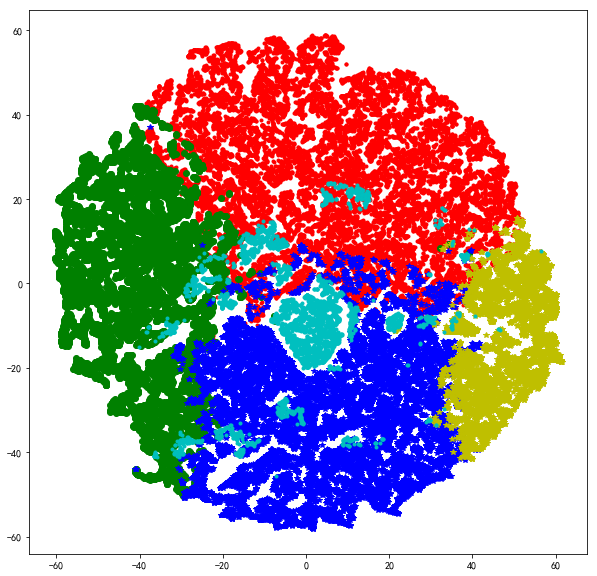

In [102]:
# 不同类别用不同颜色和样式绘图
fig = plt.figure(figsize=(10,10))
d = tsne[airline_labels['聚类类别'] == 0]
plt.plot(d[0], d[1], 'r.')
d = tsne[airline_labels['聚类类别'] == 1]
plt.plot(d[0], d[1], 'go')
d = tsne[airline_labels['聚类类别'] == 2]
plt.plot(d[0], d[1], 'b*')
d = tsne[airline_labels['聚类类别'] == 3]
plt.plot(d[0], d[1], 'y*')
d = tsne[airline_labels['聚类类别'] == 4]
plt.plot(d[0], d[1], 'c.')
plt.show()

#### 客户价值分析

- 客群1：C属性上最大；
- 客群2：F、M属性上最大，在R属性上最小；
- 客群3：R属性上最大，在F、M属性上最小；
- 客群4：在L、C属性上最小；
- 客群5：L属性上最大；

|客户群|排名|排名含义|
|---|---|---|
|客群1|1|重要保持客户|
|客群2|2|重要发展客户|
|客群3|3|重要挽留客户|
|客群4|4|一般客户|
|客群5|5|低价值客户|